In [22]:
import numpy as np
import netCDF4 as nc
import time
from Helper_fun import time_intersection, generate_temp_range
import os
import pyproj

from pyresample.geometry import SwathDefinition
import pyresample.kd_tree as kd_tree
from pyresample import get_area_def

In [3]:
class Output_file_from_sat_data:
    def __init__(self, file_path):
        # Create a new NetCDF file
        print(file_path)
        try:
            if os.path.exists(file_path):
                # os.chmod(file_path, 0o666)
                print("File exists")
                self.dataset = nc.Dataset(file_path, 'w', format='NETCDF4')
                self.SwathDef = None
            else:
                print("File not found:", file_path)
        except PermissionError:
            print(
                f"Permission denied: You don't have the necessary permissions to change the permissions of this file: {file_path}")
            self.dataset = None

    def create_dim(self, size_x: int, size_y: int, size_t: int):
        try:
            # self.dataset.set_fill_off()
            self.dataset.createDimension("lon", size_x)
            self.dataset.createDimension("lat", size_y)
            self.dataset.createDimension('time', size_t)
            self.dataset.createDimension('object_num', 2)
        except Exception as e:
            self.dataset.close()
            print(f"create_dim: {e}")

    def create_var_t(self, dates, time_units, calendar='gregorian'):
        try:
            new_time = self.dataset.createVariable('time', 'd', ('time',))
            new_time.units = time_units
            new_time.calendar = calendar
            new_time[:] = nc.date2num(
                dates, units=time_units, calendar=calendar)
        except Exception as e:
            self.dataset.close()
            print(f"create_var_t:\n{e}")

    def create_var_xy(self, lons, lats):
        try:
            x_var = self.dataset.createVariable(
                'lon', 'd', ('lon',), fill_value=np.nan)
            # Set x variable attributes
            x_var.long_name = "longitude"
            x_var.standard_name = "longitude"
            x_var.units = "degrees_east"
            # Set x variable
            print(lons)
            x_var[:] = lons

            y_var = self.dataset.createVariable(
                'lat', 'd', ('lat',), fill_value=np.nan)
            # Set y variable attributes
            y_var.long_name = "latitude"
            y_var.standard_name = "latitude"
            y_var.units = "degrees_north"
            # Set y variable
            y_var[:] = lats  # y[lat_limited_ind]*10*180/np.pi
        except Exception as e:
            self.dataset.close()
            print(f"create_var_xy:\n{e}")

    def create_track_variable(self, var_name, var_field):
        try:
            if var_name == 'cph':
                cph_var = self.dataset.createVariable(
                    'cph', 'i2', ('time', 'lat', 'lon'), fill_value=-1)
                # Copy variable attributes
                cph_var.cell_methods = "time: point"
                cph_var.flag_meanings = "clear liquid ice"
                cph_var.flag_values = '0s, 1s, 2s'
                cph_var.missing_value = -1
                cph_var.grid_mapping = "projection"
                cph_var.units = "1"
                cph_var.long_name = "Cloud Thermodynamic Phase"
                cph_var.standard_name = "thermodynamic_phase_of_cloud_water_particles_at_cloud_top"
                # For time-dependent variables, use the ith timestep -(cloud_mask.mask[count,:,:]-1)*50
                cph_var[:] = var_field
            elif var_name=='ctt':
                ctt_var = self.dataset.createVariable(
                    'ctt', 'f4', ('time', 'lat', 'lon'), fill_value=-1)
                # Copy variable attributes
                ctt_var.cell_methods = "time: point"
                ctt_var.missing_value = -1
                ctt_var.scale_factor = "0.1f" 
                ctt_var.add_offset = "0.f" 
                ctt_var.grid_mapping = "projection" 
                ctt_var.units = "K" 
                ctt_var.long_name = "Cloud Top Temperature" 
                ctt_var.standard_name = "air_temperature_at_cloud_top" 
                ctt_var[:] = var_field
            else:
                raise NotImplementedError(
                    "Program still doesnt work for non-cph variables")
        except Exception as e:
            self.dataset.close()
            print(f"create_track_variable:\n{e}")


    def close(self):
        self.dataset.close()



class Projection_transformer():
    def generate_lat_lon_prj(self, sat_data):
        self.x = sat_data['x'][:]
        self.y = sat_data['y'][:]
        # Satellite height

        # +6378137
        sat_h = sat_data.variables['projection'].perspective_point_height

        # Satellite longitude
        sat_lon = sat_data.variables['projection'].longitude_of_projection_origin

        # Satellite sweep
        sat_sweep = sat_data.variables['projection'].sweep_angle_axis

        # The projection x and y coordinates equals
        # the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)

        X = self.x.data * sat_h
        Y = self.y.data * sat_h
        XX, YY = np.meshgrid(X, Y)
        p = pyproj.Proj(proj='geos', h=sat_h,
                        lon_0=sat_lon, sweep=sat_sweep)
        # print(f"{p.definition_string()}\n{p.to_proj4()}")
        # ,errcheck=True) #radians=True
        # Generates lat and longitude matrixes taht indicate the corresponding latitude and longitude of each data within the field
        lon_mat, lat_mat = p(XX, YY, inverse=True)
        lon_mat[np.isinf(lon_mat)] = np.nan
        lat_mat[np.isinf(lat_mat)] = np.nan
        # Generate variables needed for the later reshaping of the data
        self.bounds = [np.nanmin(lon_mat.astype(np.float64)), np.nanmax(lon_mat.astype(
            np.float64)), np.nanmin(lat_mat.astype(np.float64)), np.nanmax(lat_mat.astype(np.float64))]
        print(f"Bounds = {self.bounds}")
        Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'
        Prj = pyproj.Proj(Proj4Args)
        AreaID = 'cyl'
        AreaName = 'cyl'
        ProjID = 'cyl'
        # print(np.nanmin(lon_mat.astype(np.float64)),np.nanmin(lat_mat.astype(np.float64)))
        ny, nx = lon_mat.shape
        # Get the projected poisions of the mst South West and North ast points: Usually outputs sth in the range 5-15
        # I have no idea how it works acually but it works so I wont question it
        SW = Prj(self.bounds[0], self.bounds[2])
        NW = Prj(self.bounds[1], self.bounds[3])
        area_extent = [SW[0], SW[1], NW[0], NW[1]]
        # print(area_extent)
        # The transformation in remap_data transforms th data from SwathDef to AreaDef
        self.AreaDef = get_area_def(
            AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)
        self.SwathDef = SwathDefinition(lons=lon_mat, lats=lat_mat)

        self.generate_new_coordinates()

    def generate_new_coordinates(self):
        self.new_cord_lon = np.linspace(
            self.bounds[0], self.bounds[1], self.x.shape[0])
        self.new_cord_lat = np.linspace(
            self.bounds[2], self.bounds[3], self.y.shape[0])

    def remap_data(self, var_name, var_field):
        # Satellite height
        if self.SwathDef == None:
            self.generate_lat_lon_prj()
        output_field = np.empty(var_field.shape)
        if len(var_field.shape) == 3:
            if var_name =="cph":
                output_field = kd_tree.resample_nearest(self.SwathDef, var_field.transpose(1, 2, 0), self.AreaDef, radius_of_influence=60000,
                                                    fill_value=-1, epsilon=5)  # reduce_data=True
            else:
                output_field = kd_tree.resample_nearest(self.SwathDef, var_field.transpose(1, 2, 0), self.AreaDef, radius_of_influence=60000,
                                                    fill_value=-1, epsilon=5)  # reduce_data=True
                # output_field = kd_tree.resample_gauss(self.SwathDef, var_field.transpose(1, 2, 0).astype(float), self.AreaDef,radius_of_influence=10000,
                #                                     fill_value=-1, sigmas=25000)  # reduce_data=True
            output_field = output_field.transpose(2, 0, 1)
            #return np.flip(output_field,1)
            return output_field
        else:
            raise NotImplementedError("2D var field remapping not yet added")


def output_file_generator_remap(cph_data, var_name, var_field, lat_limited_ind, lon_limited_ind, dates, time_ind, time_units, calendar, new_file_name, Transformer):

    start_date = dates[0]
    test = nc.Dataset(new_file_name, 'w', format='NETCDF4')
    test.close()
    # Create a new NetCDF file,
    new_dataset = Output_file_from_sat_data(new_file_name)

    # Create dimentions,
    new_dataset.create_dim(len(lon_limited_ind), len(
        lat_limited_ind), len(time_ind)),
    new_dataset.create_var_t(dates[time_ind], time_units, calendar),
    new_dataset.create_var_xy(
        Transformer.new_cord_lon[lon_limited_ind], Transformer.new_cord_lat[lat_limited_ind])
    # Create track variable
    new_dataset.create_track_variable('cph', var_field)
    # Copy variables from the original file, except the the ones that are manually set
    for var_name, var in cph_data.variables.items():
        if not (var_name in ['ctt','cph', 'x', 'y', 'time']):
            print(
                f"#################################### \n It activates for {var_name}\n###########################")
            new_var = new_dataset.dataset.createVariable(
                var_name, var.dtype, var.dimensions)
            # Copy variable attributes
            new_var.setncatts({k: var.getncattr(k) for k in var.ncattrs()})
            new_var[:] = var[time_ind] if 'time' in var.dimensions else var[:]

    # Close the new file
    new_dataset.close()

In [16]:
import subprocess
# Set up timer
start_time = time.time()

# ==================================================
# Open and load cloud top temp and cloud top phase data
# ==================================================
PyFLEXTRKR_LIB_DIR = os.environ['PyFLEXTRKR_LIB_DIR']
print("Loading data")
# CLAAS_DATA_DIR=
# cph_fp = PyFLEXTRKR_LIB_DIR+f'/TEST/cph.CPP.nc.nc'
# tmp_fp = PyFLEXTRKR_LIB_DIR+f'/TEST/ctt.nc.nc'
cph_fp = '/cluster/work/climate/dnikolo/CLAAS_Data/02_2004/CPH/CPPin20040121084500405SVMSG01MD.nc'
tmp_fp = '/cluster/work/climate/dnikolo/CLAAS_Data/02_2004/CTT/CTXin20040120194500405SVMSG01MD.nc'
cph_data = nc.Dataset(cph_fp)  # cloud_phase_file
ctt_data = nc.Dataset(tmp_fp)  # cloud_phase_file
print(f"Data loaded. Elapsed time: {time.time()-start_time}")

# ==================================================
# ==================================================

Loading data
Data loaded. Elapsed time: 5.832111835479736


In [18]:
ctt = ctt_data.variables['ctt'][:]
cph = cph_data['cph'][:]

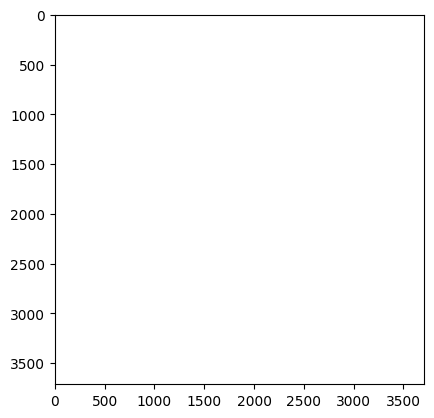

In [21]:
import matplotlib.pyplot as plt 
plt.imshow(ctt[0,:,:])

In [10]:


# ==================================================
# Load axices
# ==================================================

print(f"Setting up dimentions")

# Space dimentions
# ==================================================
x = ctt_data['x'][:]
y = ctt_data['y'][:]



# Limit data to a time period

# Generate lat and lon matrices
# lon_mat = np.ones((len(lat_limited_ind), len(x)))*(x.T * 10 * 180 / np.pi)
# lat_mat = np.ones((len(lat_limited_ind), len(x))) * \
#     (y[lat_limited_ind]*10*180/np.pi)[:, None]

# Time dimension
# ==================================================

# Get time intersection
time_ind_ctt, time_ind_cph = time_intersection(
    ctt_data['time'], cph_data['time'])

# Extract time variable for later use
# assuming the time variable is named 'time'
time_var = cph_data.variables['time']
time_units = time_var.units
calendar = time_var.calendar if hasattr(
    time_var, 'calendar') else 'standard'

# Convert time steps to dates using netCDF num2date
dates_cph = nc.num2date(time_var[:], units=time_units, calendar="gregorian")
dates_ctt= nc.num2date(ctt_data.variables['time'][:], units=time_units, calendar="gregorian")
print(f"Dimentions set. Elapsed time: {time.time()-start_time}")

# ==================================================
# ==================================================

print("Loading copies of data")
# Get reduced data arrays ctt and cph
ctt = ctt_data['ctt'][:]
cph = cph_data['cph'][:]
# [2,5,10,15,38]
print(np.count_nonzero(ctt.mask)/ctt.mask.size)
print(np.count_nonzero(cph.mask)/cph.mask.size)
Transformer = Projection_transformer()
Transformer.generate_lat_lon_prj(cph_data)


Setting up dimentions
Dimentions set. Elapsed time: 71.64608407020569
Loading copies of data
1.0
1.0
Bounds = [-81.26781815747441, 81.26032881685039, -81.18369218549527, 80.89292064320712]


In [8]:
ctt.shape

(0, 1, 1)

In [ ]:

ctt = Transformer.remap_data('ctt',ctt)
cph = Transformer.remap_data('cph',cph)
combined_mask = ctt.mask | cph.mask
print(np.count_nonzero(combined_mask)/combined_mask.size)
print(np.count_nonzero(ctt.mask)/combined_mask.size)
print(np.count_nonzero(cph.mask)/combined_mask.size)
# ctt.mask = combined_mask
# cph.mask = combined_mask

lat_ind= np.arange(len(Transformer.new_cord_lat))
lon_ind= np.arange(len(Transformer.new_cord_lon))

new_cph_file_name = PyFLEXTRKR_LIB_DIR + \
    f"/TEST/example_preprocessing/cph_resampled.nc"
new_ctt_file_name=PyFLEXTRKR_LIB_DIR + \
    f"/TEST/example_preprocessing/ctt_resampled.nc"
print("Generating output file")
output_file_generator_remap(cph_data,'cph', cph, lat_ind, lon_ind,
                            dates_cph, time_ind_cph, time_units=time_units, calendar=calendar,new_file_name=new_cph_file_name, Transformer=Transformer)

output_file_generator_remap(ctt_data,'ctt', ctt, lat_ind, lon_ind,
                            dates_ctt, time_ind_ctt, time_units=time_units, calendar=calendar,new_file_name=new_ctt_file_name, Transformer=Transformer)



ValueError: Mismatch between geometry and dataset

In [ ]:
subprocess.run(['cdo',f'setgrid,{PyFLEXTRKR_LIB_DIR+"/TEST/targetgrid.txt"}',new_cph_file_name,PyFLEXTRKR_LIB_DIR + \
    f"/TEST/example_preprocessing/cph_resampled_new_grid.nc"])
subprocess.run(['cdo',f'setgrid,{PyFLEXTRKR_LIB_DIR+"/TEST/targetgrid.txt"}',new_ctt_file_name,PyFLEXTRKR_LIB_DIR + \
    f"/TEST/example_preprocessing/cptt_resampled_new_grid.nc"])